In [1]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
import torch

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib notebook

In [22]:
def create_random_input(shape):
    num_elements = np.prod(shape)
    return np.random.randint(0, num_elements, num_elements).astype(np.float32).reshape(shape) / 128.0

def ref_conv2d(X, w, b, kernel_size, filters, strides, padding):
    return Conv2D(input_shape=X.shape, weights=[w, b], kernel_size=kernel_size, filters=filters, strides=strides, padding=padding)(X).numpy()
    
def check(fn, shape, kernel_size, filters, strides, padding):
    np.random.seed(3)
    X = create_random_input(shape)
    w = create_random_input((kernel_size[0], kernel_size[1], shape[3], filters))
    b = create_random_input((filters,))
    
    
    
    #plt.figure()
    #plt.imshow((w).reshape((w.shape[2] * w.shape[3], w.shape[0] , w.shape[1]))[0])
    #plt.colorbar()
    #plt.show()
    #
    #return



    #plt.figure()
    #plt.imshow((X).reshape((X.shape[0] * X.shape[3], X.shape[1], X.shape[2]))[0])
    #plt.colorbar()
    #plt.show()
    
    #return
    
    #X = np.ones(X.shape)
    #b = np.zeros(b.shape)
    #w = np.ones(w.shape)
    
    ref = ref_conv2d(X, w, b, kernel_size, filters, strides, padding)
    res = fn(X, w, b, kernel_size, filters, strides, padding)
    
    plt.figure()
    plt.imshow((ref - res).reshape((ref.shape[0] * ref.shape[3], ref.shape[1], ref.shape[2]))[0])
    plt.colorbar()
    plt.show()
    
    return (res == ref).all()
    #return np.allclose(res, ref)

<IPython.core.display.Javascript object>


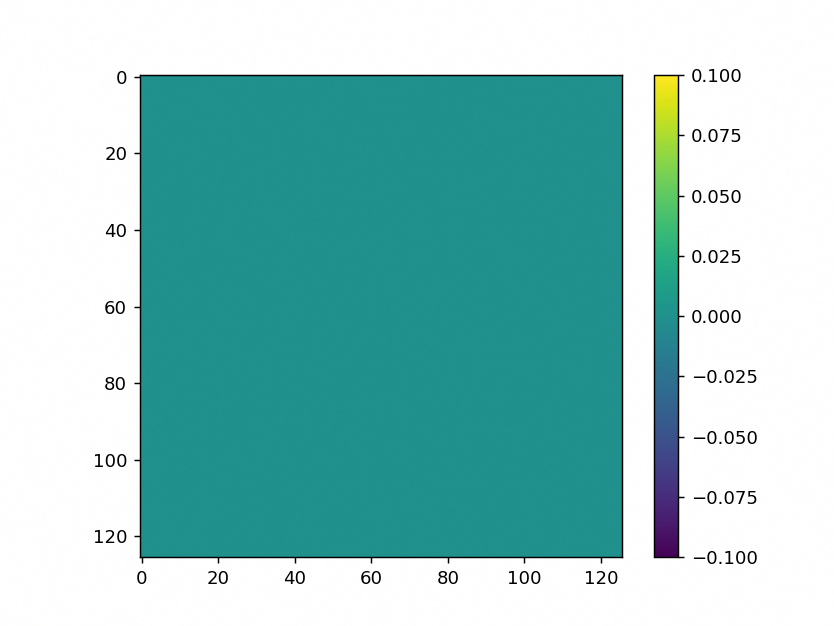

True


In [23]:
def res_conv2d(X, w, b, kernel_size, filters, strides, padding, groups = 1):
    # extract parameters
    (kernel_rows, kernel_cols, channels_in, channels_out) = w.shape
    (batch, rows_in, cols_in, channels_in_) = X.shape
    grouped_channels_out = channels_out//groups
    
    # check parameter compatibility
    assert channels_in * groups == channels_in_
    assert channels_out % groups == 0
    
    if padding == "same":
        rows_offset = kernel_rows//2
        cols_offset = kernel_cols//2
    
        # calculate output dimensions
        rows_out = (rows_in + strides[0] - 1) // strides[0]
        cols_out = (cols_in + strides[1] - 1) // strides[1]
        
    
        # create output buffer
        out = np.zeros((int(batch), int(rows_out), int(cols_out), int(groups*channels_out)))

        # prefill the output with bias
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    for g in range(groups):
                        gc = g * grouped_channels_out
                        for co in range(grouped_channels_out):
                            out[i, y, x, gc + co] = b[co]

        # convolute
        for g in range(groups):
            for i in range(batch):
                for co in range(grouped_channels_out):
                    for y in range(rows_out):
                        for x in range(cols_out):
                            sy = y * strides[0] - rows_offset
                            sx = x * strides[1] - rows_offset
                            for ci in range(channels_in):
                                for ky in range(sy, sy + kernel_rows):
                                    for kx in range(sx, sx + kernel_cols):
                                        if ky >= 0 and ky < rows_in and kx >= 0 and kx < cols_in:
                                            gc = g * grouped_channels_out
                                            out[i, y, x, gc + co] += X[i, ky , kx, gc + ci] * w[(ky - sy), (kx - sx), ci, co]


        #TODO: try indexing (g, b, co, ci, y, x, ky, kx)
        return out
    
    else:
        rows_out = (rows_in - (kernel_rows - strides[0])) // strides[0]
        cols_out = (cols_in - (kernel_cols - strides[1])) // strides[1]
        
    
        # create output buffer
        out = np.zeros((int(batch), int(rows_out), int(cols_out), int(groups*channels_out)))

        # prefill the output with bias
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    for g in range(groups):
                        gc = g * grouped_channels_out
                        for co in range(grouped_channels_out):
                            out[i, y, x, gc + co] = b[co]

        # convolute
        for g in range(groups):
            for i in range(batch):
                for co in range(grouped_channels_out):
                    for y in range(rows_out):
                        for x in range(cols_out):
                            sy = y * strides[0]
                            sx = x * strides[1]
                            for ci in range(channels_in):
                                for ky in range(sy, sy + kernel_rows):
                                    for kx in range(sx, sx + kernel_cols):
                                        gc = g * grouped_channels_out
                                        out[i, y, x, gc + co] += X[i, ky , kx, gc + ci] * w[(ky - sy), (kx - sx), ci, co]


        #TODO: try indexing (g, b, co, ci, y, x, ky, kx)
        return out

print(check(res_conv2d, (4, 128, 128, 1), (3, 3), 5, (1, 1), "valid"))
#print(check(res_conv2d, (1, 3, 3, 1), (3, 3), 1, (1, 1), "valid"))
#print(check(res_conv2d, (1, 4, 4, 1), (1, 1), 1, (1, 1), "valid"))